In [1]:
# default_exp control_refine

This contains code for refining the following control points:

* Checker
* Ellipse

The term "refine" is used here because an initial guess for the location is required.

# Import

In [2]:
# export
import numpy as np
import skimage.draw
from scipy.stats import multivariate_normal
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from camera_calib_python.utils import *

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

from camera_calib_python.image import File16bitImg

# Utility

In [4]:
# export
def pm2l(p, m):
    x, y = p
    if not np.isfinite(m): a, b, c = 1,  0,    -x
    else:                  a, b, c = m, -1, y-m*x
    return np.array([a,b,c])

In [5]:
# export
def ps2l(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    m = (y2-y1)/(x2-x1)
    return pm2l(p1, m)

In [6]:
# export
def pld(p, l):
    x, y = p
    a, b, c = l
    return np.abs(a*x + b*y + c)/np.sqrt(a**2 + b**2)

In [7]:
# export
def is_p_in_bb(p, bb):
    return p[0] >= bb[0,0] and p[1] >= bb[0,1] and p[0] <= bb[1,0] and p[1] <= bb[1,1]

In [8]:
# export
def is_bb_in_bb(bb1, bb2):
    return is_p_in_bb(bb1[0], bb2) and is_p_in_bb(bb1[1], bb2)

In [9]:
# export
def is_p_in_b(p, b): return Polygon(b).contains(Point(*p))

# Base class

I tried to make a generic control flow loop for refining control points which you can inherit and modify/implement

In [10]:
# export
class CPRefiner:
    def __init__(self, cutoff_it, cutoff_norm):
        self.cutoff_it = cutoff_it
        self.cutoff_norm = cutoff_norm
    
    def proc_arr(self, arr):            return (arr,)
    def it_preproc(self, p, b):         pass
    def get_bb(self, p, b):             raise NotImplementedError('Please implement get_bb')
    def get_W(self, p, b, bb):          return None    
    def refine_point(self, arrs, p, W): raise NotImplementedError('Please implement refine_point')

    def refine_points(self, arr, ps, bs):
        arrs = self.proc_arr(arr)
        bb_arr = array_bb(arr)
        ps_refined = []
        for idx, (p, b) in enumerate(zip(ps, bs)):
            b_init = b
            self.it_preproc(p, b)
            for it in range(self.cutoff_it):
                p_prev = p
                bb = self.get_bb(p, b)
                if not is_bb_in_bb(bb, bb_arr): p = np.full(2, np.nan); break
                w = self.get_W(p, b, bb)
                p = self.refine_point([bb_array(arr, bb) for arr in arrs], p-bb[0], w)+bb[0] 
                if np.any(np.isnan(p)): break
                if not is_p_in_b(p, b_init): p = np.full(2, np.nan); break
                if np.linalg.norm(p-p_prev) < self.cutoff_norm: break
                b = b-p_prev+p
            ps_refined.append(p)
        return np.stack(ps_refined)

# Checker

In [11]:
# export
class CheckerRefiner(CPRefiner):
    def __init__(self, hw_min, hw_max, cutoff_it, cutoff_norm):
        super().__init__(cutoff_it, cutoff_norm)
        assert_allclose(type(hw_min), int)
        assert_allclose(type(hw_max), int)
        self.hw_min, self.hw_max = hw_min, hw_max
    
    def it_preproc(self, p, b):
        ls = [ps2l(b[idx], b[np.mod(idx+1, len(b))]) for idx in range(len(b))]
        d_min = np.min([pld(p, l) for l in ls])
        hw = int(np.floor(d_min/np.sqrt(2)))
        if hw < self.hw_min: hw = self.hw_min
        if hw > self.hw_max: hw = self.hw_max
        self.hw = hw
        
    def get_bb(self, p, b):
        return np.array([[-self.hw, -self.hw],[self.hw, self.hw]]) + np.round(p).astype(np.int)   
        
    def get_W(self, p, b, bb):
        sigma = self.hw/2
        cov = np.array([[sigma**2,        0],
                        [       0, sigma**2]])
        return multivariate_normal(p, cov).pdf(np.dstack(bb_grid(bb)))

### Opencv method

In [12]:
# export
def checker_opencv(arr_dx, arr_dy, W=None):
    assert_allclose(arr_dx.shape, arr_dy.shape)
    
    # Condition array points
    ps_cond, T = condition(array_ps(arr_dx))
        
    # Form linear system 
    A = grid2ps(arr_dx, arr_dy)
    b = (A*ps_cond).sum(axis=1)
    
    # Get weighted least squares estimate
    p,_,_,_ = wlstsq(A, b, W)
    
    # Convert back to unconditioned points
    return pmm(np.linalg.inv(T), p, aug=True)

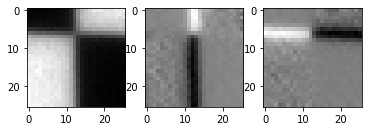

In [13]:
file_img = Path('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png')
bb = np.array([[540, 965],
               [566, 991]])
arr = bb_array(File16bitImg(file_img).array_gs, bb)
arr_dx, arr_dy = grad_array(arr)
fig, axs = plt.subplots(1,3)
for a, ax in zip([arr, arr_dx, arr_dy], axs): ax.imshow(a, cmap='gray')

In [14]:
p = checker_opencv(arr_dx, arr_dy)
p

array([11.88414035,  6.45494932])

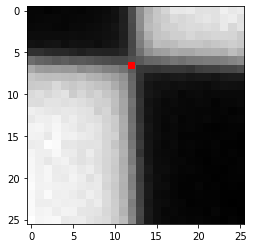

In [15]:
plt.imshow(arr, cmap='gray')
plt.plot(p[0], p[1], 'rs')

In [16]:
# export
class OpenCVCheckerRefiner(CheckerRefiner):    
    def __init__(self, hw_min, hw_max, cutoff_it, cutoff_norm):
        super().__init__(hw_min, hw_max, cutoff_it, cutoff_norm)
        
    def proc_arr(self, arr): return grad_array(arr)
    
    def refine_point(self, arrs, p, W): return checker_opencv(*arrs, W)

In [17]:
refiner = OpenCVCheckerRefiner(hw_min=3, hw_max=10, cutoff_it=20, cutoff_norm=1e-3)

In [18]:
file_img = Path('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png')
arr = File16bitImg(file_img).array_gs
ps_c_p = np.array([[858.7428864 , 633.38643518]])
bs_c_p = np.array([[[878.5844935448612, 614.1667623245968],
                    [838.8941064355354, 613.1104586040717],
                    [838.9778791064288, 652.5319092059557],
                    [878.5655638183706, 653.6357474223086]]])
ps_c_p_refined = refiner.refine_points(arr, ps_c_p, bs_c_p)
assert_allclose(ps_c_p_refined, np.array([[860.22817029, 635.16037579]]))

(620, 650)

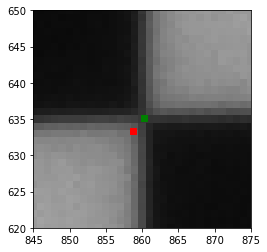

In [19]:
plt.imshow(arr, cmap='gray')
plt.plot(ps_c_p[:,0], ps_c_p[:,1], 'rs')
plt.plot(ps_c_p_refined[:,0], ps_c_p_refined[:,1], 'gs')
plt.gca().set_xlim(845, 875)
plt.gca().set_ylim(620, 650)

# Ellipse

In [20]:
# export
class EllipseRefiner(CPRefiner):
    def __init__(self, cutoff_it, cutoff_norm):
        super().__init__(cutoff_it, cutoff_norm)
            
    def get_bb(self, p, b):
        return np.c_[np.floor(np.min(b, axis=0)), 
                      np.ceil(np.max(b, axis=0))+1].T.astype(np.int)
        
    def get_W(self, p, b, bb): 
        return skimage.draw.polygon2mask(bb_sz(bb), b-bb[0]).astype(np.float)

### dual conic method

In [21]:
# export
def fit_conic(arr_dx, arr_dy, W=None):
    assert_allclose(arr_dx.shape, arr_dy.shape)
    
    # Condition array points
    ps_cond, T = condition(array_ps(arr_dx))
        
    # Form homogeneous coordinates of lines
    ls = grid2ps(arr_dx, arr_dy)
    ls = np.c_[ls, -(ls*ps_cond).sum(axis=1)]
        
    # Form linear system 
    A = np.c_[ls[:, 0]**2, ls[:, 0]*ls[:, 1], ls[:, 1]**2, ls[:, 0]*ls[:, 2], ls[:, 1]*ls[:, 2]]
    b = -ls[:, 2]**2
    
    # Get weighted least squares estimate
    aq_inv,_,_,_ = wlstsq(A, b, W)
    
    # Get conic matrix
    Aq_inv = np.array([[  aq_inv[0], aq_inv[1]/2, aq_inv[3]/2],
                       [aq_inv[1]/2,   aq_inv[2], aq_inv[4]/2],
                       [aq_inv[3]/2, aq_inv[4]/2,           1]])
    Aq = np.linalg.inv(Aq_inv)

    # Rescale conic matrix to take conditioning into account
    return T.T@Aq@T

In [22]:
# export
def ellipse_dualconic(arr_dx, arr_dy, W=None):
    Aq = fit_conic(arr_dx, arr_dy, W)
    return conic2ellipse(Aq)

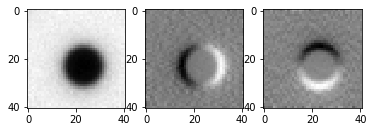

In [23]:
file_img = Path('data/dot_vision_circle/SERIAL_19061245_DATETIME_2020-05-17-20:48:11-005188_CAM_1_FRAMEID_0_COUNTER_1.png')
bb = np.array([[520, 975],
               [561, 1016]])
arr = bb_array(File16bitImg(file_img).array_gs, bb)
arr_dx, arr_dy = grad_array(arr)
fig, axs = plt.subplots(1,3)
for a, ax in zip([arr, arr_dx, arr_dy], axs): ax.imshow(a, cmap='gray')

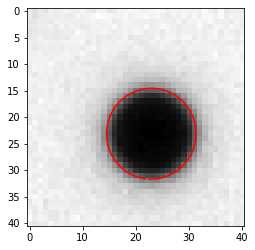

In [24]:
e = ellipse_dualconic(arr_dx, arr_dy)
ps_e = sample_ellipse(*e, 100)
plt.imshow(arr, cmap='gray')
plt.plot(ps_e[:,0], ps_e[:,1],'-r')

In [25]:
# export
class DualConicEllipseRefiner(EllipseRefiner):    
    def __init__(self, cutoff_it, cutoff_norm):
        super().__init__(cutoff_it, cutoff_norm)
        
    def proc_arr(self, arr): return grad_array(arr)
    
    def refine_point(self, arrs, p, W): return np.array(ellipse_dualconic(*arrs, W)[:2])

In [26]:
refiner = DualConicEllipseRefiner(cutoff_it=20, cutoff_norm=1e-3)

In [27]:
file_img = Path('data/dot_vision_circle/SERIAL_19061245_DATETIME_2020-05-17-20:48:11-005188_CAM_1_FRAMEID_0_COUNTER_1.png')
arr = File16bitImg(file_img).array_gs
ps_c_p = np.array([[ 89.74539133, 996.88665043]])
bs_c_p = np.array([[[89.54655384855116, 1029.6488057591937],
                    [57.63816166782976, 996.9142817777084],
                    [89.94410826454079, 964.1443565486551],
                    [121.88933256121098, 996.8589874927425]]])
ps_c_p_refined = refiner.refine_points(arr, ps_c_p, bs_c_p)
assert_allclose(ps_c_p_refined, np.array([[ 95.89891747, 997.13242706]]))

(982, 1012)

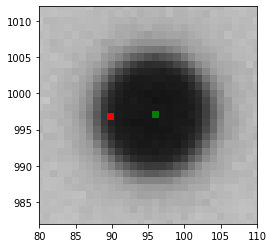

In [28]:
plt.imshow(arr, cmap='gray')
plt.plot(ps_c_p[:,0], ps_c_p[:,1], 'rs')
plt.plot(ps_c_p_refined[:,0], ps_c_p_refined[:,1], 'gs')
plt.gca().set_xlim(80,  110)
plt.gca().set_ylim(982, 1012)

# Build

In [29]:
!nbdev_build_lib

Converted cb_geom.ipynb.
Converted control_refine.ipynb.
Converted coordinate_graph.ipynb.
Converted fiducial_detect.ipynb.
Converted image.ipynb.
Converted modules.ipynb.
Converted test.ipynb.
Converted utils.ipynb.
